# Sentiment analysis with pretrained word vectors

In Chapter 15, Word Embeddings, we discussed how to learn domain-specific word embeddings. Word2vec, and related learning algorithms, produce high-quality word vectors, but require large datasets. Hence, it is common that research groups share word vectors trained on large datasets, similar to the weights for pretrained deep learning models that we encountered in the section on transfer learning in the previous chapter.

We are now going to illustrate how to use pretrained Global Vectors for Word Representation (GloVe) provided by the Stanford NLP group with the IMDB review dataset.

In [1]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt
import seaborn as sns

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [3]:
sns.set_style('whitegrid')
np.random.seed(42)

In [4]:
results_path = Path('results', 'sentiment_imdb')
if not results_path.exists():
    results_path.mkdir(parents=True)

## Load Reviews

We are going to load the IMDB dataset from the source for manual preprocessing.

Data source: [Stanford IMDB Reviews Dataset](http://ai.stanford.edu/~amaas/data/sentiment/)

Dowload extract, and place the content in a newly created `data` folder so that your directory structure looks as follows:
```
19_recurrent_neural_nets
 |-data
     |-aclimdb
          |-train
              |-neg
              |-pos
              ...
          |-test
          |-imdb.vocab
```

In [5]:
path = Path('data', 'aclImdb')

In [6]:
files = path.glob('**/*.txt')
len(list(files))

100006

In [7]:
files = path.glob('*/**/*.txt')
outcomes = set()
data = []
for f in files:
    if f.stem.startswith(('urls_', 'imdbEr')):
        continue
    _, _, data_set, outcome = f.parent.as_posix().split('/')
    if outcome == 'unsup':
        continue
    data.append([data_set, int(outcome == 'pos'),
                 f.read_text(encoding='latin1')])

In [8]:
data = pd.DataFrame(data, columns=['dataset', 'label', 'review'])

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   dataset  50000 non-null  object
 1   label    50000 non-null  int64 
 2   review   50000 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [10]:
train_data = data.loc[data.dataset=='train', ['label', 'review']]
test_data = data.loc[data.dataset=='test', ['label', 'review']]

In [11]:
train_data.label.value_counts()

0    12500
1    12500
Name: label, dtype: int64

In [12]:
test_data.label.value_counts()

0    12500
1    12500
Name: label, dtype: int64

## Prepare Data

### Tokenizer

Keras provides a tokenizer that we use to convert the text documents to integer-encoded sequences, as shown here:

In [13]:
num_words = 10000
t = Tokenizer(num_words=num_words, 
              lower=True, 
              oov_token=2)
t.fit_on_texts(train_data.review)

In [14]:
vocab_size = len(t.word_index) + 1
vocab_size

88586

In [15]:
train_data_encoded = t.texts_to_sequences(train_data.review)
test_data_encoded = t.texts_to_sequences(test_data.review)

In [16]:
max_length = 100

### Pad Sequences

We also use the pad_sequences function to convert the list of lists (of unequal length) to stacked sets of padded and truncated arrays for both the train and test datasets:

In [17]:
X_train_padded = pad_sequences(train_data_encoded, 
                            maxlen=max_length, 
                            padding='post',
                           truncating='post')
y_train = train_data['label']
X_train_padded.shape

(25000, 100)

In [18]:
X_test_padded = pad_sequences(test_data_encoded, 
                            maxlen=max_length, 
                            padding='post',
                           truncating='post')
y_test = test_data['label']
X_test_padded.shape

(25000, 100)

## Load Embeddings

Assuming we have downloaded and unzipped the GloVe data to the location indicated in the code, we now create a dictionary that maps GloVe tokens to 100-dimensional real-valued vectors, as follows:

In [19]:
# load the whole embedding into memory
glove_path = Path('..', 'data', 'glove', 'glove.6B.100d.txt')
embeddings_index = dict()

for line in glove_path.open(encoding='latin1'):
    values = line.split()
    word = values[0]
    try:
        coefs = np.asarray(values[1:], dtype='float32')
    except:
        continue
    embeddings_index[word] = coefs

In [20]:
print('Loaded {:,d} word vectors.'.format(len(embeddings_index)))

Loaded 399,883 word vectors.


There are around 340,000 word vectors that we use to create an embedding matrix that matches the vocabulary so that the RNN model can access embeddings by the token index:

In [21]:
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [22]:
embedding_matrix.shape

(88586, 100)

## Define Model Architecture

The difference between this and the RNN setup in the previous example is that we are going to pass the embedding matrix to the embedding layer and set it to non-trainable, so that the weights remain fixed during training:

In [23]:
embedding_size = 100

In [24]:
rnn = Sequential([
    Embedding(input_dim=vocab_size, 
              output_dim= embedding_size, 
              input_length=max_length,
              weights=[embedding_matrix], 
              trainable=False),
    GRU(units=32,  dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])
rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          8858600   
_________________________________________________________________
gru (GRU)                    (None, 32)                12864     
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 8,871,497
Trainable params: 12,897
Non-trainable params: 8,858,600
_________________________________________________________________


In [25]:
rnn.compile(loss='binary_crossentropy',
            optimizer='RMSProp',
            metrics=['accuracy', 
                     tf.keras.metrics.AUC(name='AUC')])

In [26]:
rnn_path = (results_path / 'lstm.pretrained.h5').as_posix()

checkpointer = ModelCheckpoint(filepath=rnn_path,
                               verbose=1,
                               monitor='val_AUC',
                               mode='max',
                               save_best_only=True)

In [27]:
early_stopping = EarlyStopping(monitor='val_AUC',
                               patience=5,
                               mode='max',
                               restore_best_weights=True)

In [28]:
training = rnn.fit(X_train_padded,
                   y_train,
                   batch_size=256,
                   epochs=100,
                   validation_data=(X_test_padded,
                                    y_test),
                   callbacks=[early_stopping,
                              checkpointer],
                   verbose=1)

Epoch 1/100
98/98 [==============================] - 56s 547ms/step - loss: 0.6970 - accuracy: 0.5359 - AUC: 0.5368 - val_loss: 0.6739 - val_accuracy: 0.5779 - val_AUC: 0.6265

Epoch 00001: val_AUC improved from -inf to 0.62650, saving model to results/sentiment_imdb\lstm.pretrained.h5
Epoch 2/100
98/98 [==============================] - 53s 542ms/step - loss: 0.6425 - accuracy: 0.6273 - AUC: 0.6783 - val_loss: 0.5498 - val_accuracy: 0.7264 - val_AUC: 0.7964

Epoch 00002: val_AUC improved from 0.62650 to 0.79642, saving model to results/sentiment_imdb\lstm.pretrained.h5
Epoch 3/100
98/98 [==============================] - 53s 543ms/step - loss: 0.5579 - accuracy: 0.7235 - AUC: 0.7874 - val_loss: 0.5327 - val_accuracy: 0.7401 - val_AUC: 0.8290

Epoch 00003: val_AUC improved from 0.79642 to 0.82903, saving model to results/sentiment_imdb\lstm.pretrained.h5
Epoch 4/100
98/98 [==============================] - 53s 544ms/step - loss: 0.5175 - accuracy: 0.7493 - AUC: 0.8234 - val_loss: 0.532

98/98 [==============================] - 54s 555ms/step - loss: 0.3687 - accuracy: 0.8322 - AUC: 0.9154 - val_loss: 0.3828 - val_accuracy: 0.8213 - val_AUC: 0.9079

Epoch 00030: val_AUC did not improve from 0.90835
Epoch 31/100
98/98 [==============================] - 53s 539ms/step - loss: 0.3708 - accuracy: 0.8315 - AUC: 0.9145 - val_loss: 0.3848 - val_accuracy: 0.8198 - val_AUC: 0.9087

Epoch 00031: val_AUC improved from 0.90835 to 0.90867, saving model to results/sentiment_imdb\lstm.pretrained.h5
Epoch 32/100
98/98 [==============================] - 52s 531ms/step - loss: 0.3677 - accuracy: 0.8339 - AUC: 0.9160 - val_loss: 0.4000 - val_accuracy: 0.8140 - val_AUC: 0.9085

Epoch 00032: val_AUC did not improve from 0.90867
Epoch 33/100
98/98 [==============================] - 52s 532ms/step - loss: 0.3632 - accuracy: 0.8367 - AUC: 0.9181 - val_loss: 0.3819 - val_accuracy: 0.8233 - val_AUC: 0.9092

Epoch 00033: val_AUC improved from 0.90867 to 0.90924, saving model to results/sentiment

In [29]:
y_score = rnn.predict(X_test_padded)
roc_auc_score(y_score=y_score.squeeze(), y_true=y_test)

0.9121198848000001

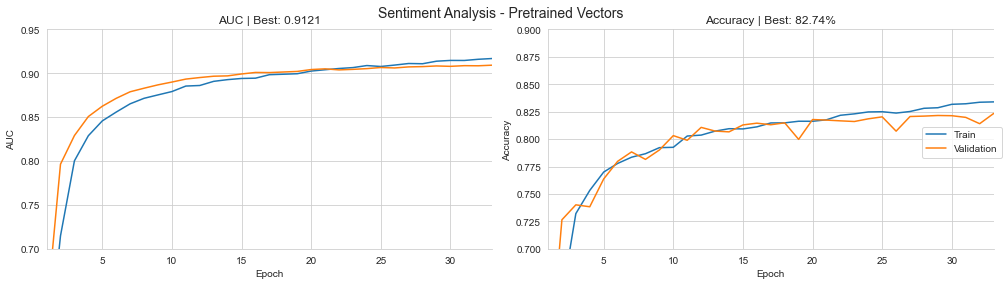

In [30]:
df = pd.DataFrame(training.history)
best_auc = df.val_AUC.max()
best_acc = df.val_accuracy.max()

fig, axes = plt.subplots(ncols=2, figsize=(14,4))
df.index = df.index.to_series().add(1)
df[['AUC', 'val_AUC']].plot(ax=axes[0], 
                            title=f'AUC | Best: {best_auc:.4f}', 
                            legend=False, 
                            xlim=(1, 33),
                            ylim=(.7, .95))

axes[0].axvline(df.val_AUC.idxmax(), ls='--', lw=1, c='k')
df[['accuracy', 'val_accuracy']].plot(ax=axes[1], 
                                              title=f'Accuracy | Best: {best_acc:.2%}', 
                                              legend=False, 
                                              xlim=(1, 33),
                                      ylim=(.7, .9))
axes[1].axvline(df.val_accuracy.idxmax(), ls='--', lw=1, c='k')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('AUC')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
fig.suptitle('Sentiment Analysis - Pretrained Vectors', fontsize=14)
fig.legend(['Train', 'Validation'], loc='center right')

sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9)
fig.savefig(results_path / 'imdb_pretrained', dpi=300);